## GeoCroissant to OGC-TDML (pytdml) Converter
<img src="GeoCroissant.jpg" alt="GeoCroissant" width="150" style="float: right; margin-left: 20px;"/>

This notebook demonstrates how to convert a dataset from the [GeoCroissant](https://github.com/mlcommons/croissant) JSON-LD format to the [OGC-TDML](https://github.com/openrsgis/pytdml) using both `mlcroissant` and `pytdml` for validation and schema compliance.

### **How it works:**
- **Validates** the GeoCroissant JSON using `mlcroissant` for standard metadata fields.
- **Directly extracts** the `variableMeasured` and `distribution` arrays from the JSON to ensure all classes, bands, and data entries are captured.
- **Builds a TDML object** using the `pytdml` object model, ensuring strict schema compliance.
- **Writes the TDML file** using `pytdml.io.write_to_json`.

## **Converter Code**

```python
import json
from mlcroissant import Dataset as CroissantDataset
import pytdml
import pytdml.io
from pytdml.type.extended_types import EOTrainingDataset, AI_EOTrainingData, AI_PixelLabel, MD_Band, AI_EOTask

def get_distribution_from_json(json_path):
    with open(json_path) as f:
        croissant = json.load(f)
    return croissant.get("distribution", [])

def get_variable_measured_from_json(json_path):
    with open(json_path) as f:
        croissant = json.load(f)
    return croissant.get("variableMeasured", [])

def convert_geocroissant_to_tdml_objectmodel(geocroissant_path, tdml_output_path):
    croissant = CroissantDataset(geocroissant_path)
    meta = croissant.metadata

    distribution = get_distribution_from_json(geocroissant_path)
    variable_measured = get_variable_measured_from_json(geocroissant_path)

    identifier = getattr(meta, 'id', None) or getattr(meta, 'uuid', None) or ''
    name = getattr(meta, 'name', '') or ''
    description = getattr(meta, 'description', '')
    if not description:
        description = "No description provided."
    license_ = getattr(meta, 'license', '')
    if isinstance(license_, list):
        license_ = license_[0] if license_ else ''
    providers = getattr(meta, 'creators', [])
    created_time = getattr(meta, 'created_time', '') or getattr(meta, 'date_created', '') or ''
    updated_time = getattr(meta, 'updated_time', '') or getattr(meta, 'date_modified', '') or ''
    if not created_time:
        created_time = "2025-07-17"
    if not updated_time:
        updated_time = "2025-07-17"
    version = getattr(meta, 'version', '') or ''
    spatial_coverage = getattr(meta, 'spatial_coverage', None)

    classes = []
    bands = []
    for v in variable_measured:
        name_v = v.get('name', '') if isinstance(v, dict) else ''
        description_v = v.get('description', '') if isinstance(v, dict) else ''
        unit_text = v.get('unitText', None) if isinstance(v, dict) else None
        if unit_text:
            bands.append(MD_Band(description=name_v, units=unit_text))
        else:
            classes.append({"key": name_v, "value": description_v})

    data = []
    for i in range(0, len(distribution), 2):
        img_entry = distribution[i]
        mask_entry = distribution[i+1] if i+1 < len(distribution) else None
        img_url = img_entry.get('contentUrl', '') if isinstance(img_entry, dict) else ''
        data_id = f"data_{i//2}"
        labels = []
        if mask_entry:
            mask_url = mask_entry.get('contentUrl', '') if isinstance(mask_entry, dict) else ''
            mask_format = mask_entry.get('encodingFormat', 'image/tiff') if isinstance(mask_entry, dict) else 'image/tiff'
            labels = [AI_PixelLabel(
                type="AI_PixelLabel",
                image_url=[mask_url],
                image_format=[mask_format],
                class_=""
            )]
        data.append(AI_EOTrainingData(
            type="AI_EOTrainingData",
            id=data_id,
            data_url=[img_url],
            labels=labels
        ))

    if not data:
        raise ValueError("No data entries found. The distribution field may be empty or not parsed correctly.")

    tasks = [AI_EOTask(
        type="AI_EOTask",
        id="task_0",
        name="Burn Scar Segmentation",
        description="Semantic segmentation of burn scars in satellite imagery.",
        input_type="image",
        output_type="mask",
        taskType="segmentation"
    )]

    extent = None
    if spatial_coverage and hasattr(spatial_coverage, 'geo'):
        geo = spatial_coverage.geo
        coords = geo.get('coordinates', [[]])[0] if isinstance(geo, dict) else getattr(geo, 'coordinates', [[]])[0]
        if coords:
            min_x = min(c[0] for c in coords)
            min_y = min(c[1] for c in coords)
            max_x = max(c[0] for c in coords)
            max_y = max(c[1] for c in coords)
            extent = [min_x, min_y, max_x, max_y]

    tdml_obj = EOTrainingDataset(
        type="AI_EOTrainingDataset",
        id=identifier,
        name=name,
        description=description,
        license=license_,
        providers=providers,
        created_time=created_time,
        updated_time=updated_time,
        version=version,
        tasks=tasks,
        classes=classes,
        bands=bands,
        data=data,
        extent=extent,
        amount_of_training_data=len(data),
        number_of_classes=len(classes)
    )

    pytdml.io.write_to_json(tdml_obj, tdml_output_path)
    print(f"TDML file written to {tdml_output_path}")
```

### Run the GeoCroissant to TDML Converter

The following command runs the converter script to transform your GeoCroissant JSON file into a TDML-compliant JSON file.

```bash
!python geocroissant_converter_objectmodel.py hls_burn_scars_croissant.json hls_burn_scars_geocroissant_to_ogctdml.json
```

- **Input:** `hls_burn_scars_croissant.json` (GeoCroissant format)
- **Output:** `hls_burn_scars_geocroissant_to_ogctdml.json` (TDML format)

This step ensures your dataset is ready for use in ML workflows that require the TDML format.
```

In [1]:
!python geocroissant_converter_objectmodel.py hls_burn_scars_croissant.json hls_burn_scars_geocroissant_to_ogctdml.json

variable_measured raw: [{'name': 'background', 'description': 'Background pixels (non-burn areas)'}, {'name': 'burn_scar', 'description': 'Burn scar pixels'}, {'name': 'Band 1 (Blue)', 'unitText': 'reflectance'}, {'name': 'Band 2 (Green)', 'unitText': 'reflectance'}, {'name': 'Band 3 (Red)', 'unitText': 'reflectance'}, {'name': 'Band 4 (NIR)', 'unitText': 'reflectance'}, {'name': 'Band 5 (SWIR1)', 'unitText': 'reflectance'}, {'name': 'Band 6 (SWIR2)', 'unitText': 'reflectance'}]
variable_measured types: [<class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>]
Entry: {'name': 'background', 'description': 'Background pixels (non-burn areas)'}
Entry: {'name': 'burn_scar', 'description': 'Burn scar pixels'}
Entry: {'name': 'Band 1 (Blue)', 'unitText': 'reflectance'}
Entry: {'name': 'Band 2 (Green)', 'unitText': 'reflectance'}
Entry: {'name': 'Band 3 (Red)', 'unitText': 'reflectance'}
Entry: {'name': 'Band 4 (NIR)', 'un

### Load and Inspect the OGC-TDML Dataset

This code loads the generated TDML file using `pytdml` and prints key dataset information:

- **Purpose:**  
  - Verifies that the TDML file is valid and can be loaded.
  - Displays the dataset name, number of training samples, and number of classes.
- **Expected Output:**  
  - The correct dataset name.
  - The total number of image/mask pairs.
  - The number of semantic classes in the dataset.

In [2]:
import pytdml.io
    
training_dataset = pytdml.io.read_from_json("hls_burn_scars_geocroissant_to_ogctdml.json")  # read from TDML json file
print("Load training dataset: " + training_dataset.name)
print("Number of training samples: " + str(training_dataset.amount_of_training_data))
print("Number of classes: " + str(training_dataset.number_of_classes))

Load training dataset: HLS_Burn_Scars_Semantic_Segmentation_Dataset
Number of training samples: 804
Number of classes: 2


## Loading and Visualizing a TDML Segmentation Dataset with GDAL and PyTorch

This example demonstrates how to load a segmentation dataset described by a TDML (Training Data Markup Language) JSON file, download the image and mask pairs, and visualize them using PyTorch, GDAL, and Matplotlib.

**Notes:**
- This class will automatically download and cache the images and masks locally.
- The image and mask are loaded using GDAL, supporting multi-band geospatial TIFFs.
- The mask is assumed to be the first label in the `labels` list for each data entry.
- Adjust the TDML file path as needed for your dataset.

Image shape: torch.Size([6, 512, 512])
Mask shape: torch.Size([512, 512])


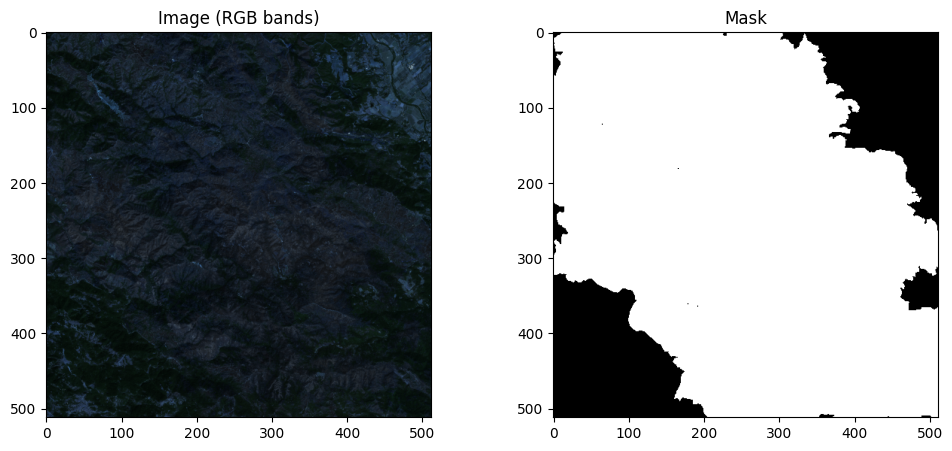

In [3]:
import os
import requests
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from osgeo import gdal
import json
import matplotlib.pyplot as plt

class TDMLSegmentationDatasetGDAL(Dataset):
    def __init__(self, tdml_path, transform=None, cache_dir="./cache"):
        with open(tdml_path) as f:
            tdml = json.load(f)
        self.data = tdml["data"]
        self.transform = transform
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)

        # Pair image and mask URLs
        self.pairs = []
        for entry in self.data:
            img_url = entry.get("dataURL", [None])[0]
            mask_url = None
            if entry.get("labels") and entry["labels"][0].get("imageURL"):
                mask_url = entry["labels"][0]["imageURL"][0]
            if img_url and mask_url:
                self.pairs.append((img_url, mask_url))

    def _download(self, url):
        filename = os.path.join(self.cache_dir, os.path.basename(url))
        if not os.path.exists(filename):
            r = requests.get(url)
            r.raise_for_status()
            with open(filename, "wb") as f:
                f.write(r.content)
        return filename

    def _load_image(self, path):
        ds = gdal.Open(path)
        if ds is None:
            raise RuntimeError(f"GDAL could not open {path}")
        bands = []
        for i in range(1, ds.RasterCount + 1):
            band = ds.GetRasterBand(i).ReadAsArray()
            bands.append(band)
        img = np.stack(bands, axis=-1)  # (H, W, bands)
        return img

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_url, mask_url = self.pairs[idx]
        img_path = self._download(img_url)
        mask_path = self._download(mask_url)
        img = self._load_image(img_path)
        mask = self._load_image(mask_path)
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img).permute(2, 0, 1).float()  # (C, H, W)
        mask = torch.from_numpy(mask).long()
        if mask.ndim == 3:
            mask = mask.squeeze()
        return img, mask

# Usage example:
dataset = TDMLSegmentationDatasetGDAL("hls_burn_scars_geocroissant_to_ogctdml.json", transform=None)
img, mask = dataset[0]
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

# Plotting
img_np = img.permute(1, 2, 0).numpy()
mask_np = mask.numpy()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
if img_np.shape[2] >= 3:
    plt.imshow(img_np[:, :, :3] / np.max(img_np[:, :, :3]))
    plt.title("Image (RGB bands)")
else:
    plt.imshow(img_np[:, :, 0], cmap='grey')
    plt.title("Image (Band 1)")
plt.axis('on')
plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='grey', vmin=0, vmax=1)
plt.title("Mask")
plt.axis('on')
plt.show()